<a href="https://colab.research.google.com/github/raktim711/AIMS-project---Anomaly-Detection/blob/main/ModelTesting_after_processing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classification power and AD with varying jet $p_T$ thresholds

In this notebook we take a preprocessed file and test the how well can the data be classified by varying minimum jet $p_T$ thresholds. The plots get stored in a folder in google drive.

In [1]:
import os
import math
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

In [2]:
# Set plotting style at module level
plt.rcParams.update({
    # Font sizes
    'font.size': 18,
    'axes.labelsize': 18,
    'axes.titlesize': 18,
    'xtick.labelsize': 16,
    'ytick.labelsize': 16,
    'legend.fontsize': 16,
    'legend.frameon': False,  # No box around legend
    'axes.grid': False,
    # Tick settings
    'xtick.direction': 'in',
    'ytick.direction': 'in',
    'xtick.major.size': 10,
    'ytick.major.size': 10,
    'xtick.minor.size': 5,
    'ytick.minor.size': 5,
    'xtick.major.width': 1,
    'ytick.major.width': 1,
    'xtick.top': True,
    'ytick.right': True,
    'xtick.minor.visible': True,
    'ytick.minor.visible': True
})

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import pickle

with open("/content/drive/MyDrive/Datasets/balanced_dfs_no_dup_OR.pkl", "rb") as f:
    ML_dict = pickle.load(f)


## Details of the data
ML_dict is a dictionary with the dataframes

```
'all_signals', 'HAHMggf', 'HNLeemu', 'HtoSUEP',
'VBF_H125_a55a55_4b_ctau1_filtered', 'Znunu',
'ggF_H125_a16a16_4b_ctau10_filtered', 'hh_bbbb_vbf_novhh_5fs_l1cvv1cv1'
```
All of them have the same columns:

```
'j0pt', 'j0eta', 'j0phi', 'j1pt', 'j1eta', 'j1phi', 'j2pt', 'j2eta',
       'j2phi', 'j3pt', 'j3eta', 'j3phi', 'j4pt', 'j4eta', 'j4phi', 'j5pt',
       'j5eta', 'j5phi', 'e0pt', 'e0eta', 'e0phi', 'e1pt', 'e1eta', 'e1phi',
       'e2pt', 'e2eta', 'e2phi', 'mu0pt', 'mu0eta', 'mu0phi', 'mu1pt',
       'mu1eta', 'mu1phi', 'mu2pt', 'mu2eta', 'mu2phi', 'ph0pt', 'ph0eta',
       'ph0phi', 'ph1pt', 'ph1eta', 'ph1phi', 'ph2pt', 'ph2eta', 'ph2phi',
       'METpt', 'METeta', 'METphi', 'run_number', 'event_number', 'weight',
       'target'
```
When loaded with `balanced_dfs_no_dup_processed.pkl`, the dataframes contain events for which there are no duplicate objects. Events with undefined METpt have been removed. All events where all objects have 0 pt have been removed. All of them have equal amount of signal and background ('target' == 'EB_test').

When loaded with `balanced_dfs_no_dup_OR.pkl`, in addition to the above mentioned processing, overlap removal has also been performed.

## Random Forest

In [ ]:
# Consistent style
plt.rcParams['figure.figsize'] = (8,6)
plt.rcParams['font.size'] = 12

# Jet-pt thresholds you want to test
JET_PT_THRESHOLDS = [5, 15, 25, 45, 60, 80]

# Which jet columns to use
JET_PT_COLS = [f"j{i}pt" for i in range(6)]   # j0pt ... j5pt


In [ ]:
PLOT_BASE_DIR = "/content/drive/MyDrive/Datasets/plots_with_OR"
os.makedirs(PLOT_BASE_DIR, exist_ok=True)

### Define all the necessary helper functions

In [ ]:
def apply_jet_pt_threshold(df, threshold):
    """
    Returns a filtered dataframe where all nonzero jets have pt >= threshold.
    Condition: for each jet jX,
      keep event if (jXpt == 0) or (jXpt >= threshold)
    """
    mask = np.ones(len(df), dtype=bool)
    for col in JET_PT_COLS:
        if col in df.columns:
            mask &= (df[col] == 0) | (df[col] >= threshold)
    return df[mask]


In [ ]:
def prepare_dataset(df):
    """
    Drops unwanted columns, splits dataset once for reproducibility.
    """
    # Features = all physics columns except bookkeeping
    drop_cols = ["run_number", "event_number", "target", "weight"]
    feature_cols = [c for c in df.columns if c not in drop_cols]

    X = df[feature_cols].copy()
    y = (df["target"] == "EB_test").astype(int)

    # Single train/test split to be reused for all thresholds
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, stratify=y, random_state=42
    )

    return X_train, X_test, y_train, y_test, feature_cols


In [ ]:
def train_and_evaluate_rf(X_train, y_train, X_test, y_test):
    """Trains a simple, stable Random Forest and returns ROC curve + AUC."""

    rf = RandomForestClassifier(
        n_estimators=300,
        max_depth=None,
        min_samples_split=2,
        random_state=42,
        n_jobs=-1
    )
    rf.fit(X_train, y_train)

    # Probabilities for ROC
    y_score = rf.predict_proba(X_test)[:, 1]

    fpr, tpr, _ = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)

    return rf, fpr, tpr, roc_auc


In [ ]:
def plot_roc_curves(roc_results, dataset_name, save_dir):
    plt.figure()
    for T, (fpr, tpr, roc_auc) in roc_results.items():
        plt.plot(fpr, tpr, label=f"T={T} GeV (AUC={roc_auc:.3f})")

    plt.plot([0,1], [0,1], "k--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curves — {dataset_name}")
    plt.legend()
    plt.grid(True)

    plt.savefig(os.path.join(save_dir, "roc_curves.png"), dpi=200, bbox_inches="tight")
    plt.close()


In [ ]:
def plot_auc_vs_threshold(roc_results, dataset_name, save_dir):
    thresholds = list(roc_results.keys())
    auc_vals = [roc_results[T][2] for T in thresholds]

    plt.figure()
    plt.plot(thresholds, auc_vals, marker="o")
    plt.xlabel("Jet $p_T$ Threshold [GeV]")
    plt.ylabel("AUC")
    plt.title(f"AUC vs Jet $p_T$ Threshold — {dataset_name}")
    plt.grid(True)

    plt.savefig(os.path.join(save_dir, "auc_vs_threshold.png"), dpi=200, bbox_inches="tight")
    plt.close()


In [ ]:
def plot_event_yields(counts_sig, counts_bkg, dataset_name, save_dir):
    plt.figure()
    plt.plot(list(counts_sig.keys()), list(counts_sig.values()),
             marker="o", label="Signal")
    plt.plot(list(counts_bkg.keys()), list(counts_bkg.values()),
             marker="s", label="Background")

    plt.xlabel("Jet $p_T$ Threshold [GeV]")
    plt.ylabel("Events passing selection")
    plt.title(f"Event Yields — {dataset_name}")
    plt.legend()
    plt.grid(True)

    plt.savefig(os.path.join(save_dir, "event_yields.png"), dpi=200, bbox_inches="tight")
    plt.close()


In [ ]:
def compare_feature_importances(
        rf_low, rf_high, feature_cols, dataset_name, save_dir,
        low_T=15, high_T=60, topN=12):

    importances_low = rf_low.feature_importances_
    importances_high = rf_high.feature_importances_

    idx = np.argsort(importances_high)[::-1][:topN]

    plt.figure(figsize=(9,6))
    plt.barh(
        [feature_cols[i] for i in idx],
        importances_high[idx],
        alpha=0.7,
        label=f"T={high_T} GeV"
    )
    plt.barh(
        [feature_cols[i] for i in idx],
        importances_low[idx],
        alpha=0.7,
        label=f"T={low_T} GeV"
    )

    plt.gca().invert_yaxis()
    plt.xlabel("Feature Importance")
    plt.title(f"Feature Importance Comparison — {dataset_name}")
    plt.legend()

    plt.savefig(os.path.join(save_dir, "feature_importances.png"), dpi=200, bbox_inches="tight")
    plt.close()


### Main function

In [ ]:
def run_full_analysis(dataset_name):
    print(f"=== Running full analysis for: {dataset_name} ===")

    df = ML_dict[dataset_name].copy()

    # Create directory for this dataset's plots
    save_dir = os.path.join(PLOT_BASE_DIR, dataset_name)
    os.makedirs(save_dir, exist_ok=True)

    # Prepare once
    X_train_all, X_test_all, y_train_all, y_test_all, feature_cols = prepare_dataset(df)

    roc_results = {}
    counts_sig = {}
    counts_bkg = {}
    rf_models = {}

    # Loop thresholds
    for T in JET_PT_THRESHOLDS:
        print(f"\n→ Applying jet pt threshold T = {T} GeV")

        X_train = apply_jet_pt_threshold(X_train_all, T)
        y_train = y_train_all.loc[X_train.index]

        X_test = apply_jet_pt_threshold(X_test_all, T)
        y_test = y_test_all.loc[X_test.index]

        counts_sig[T] = (y_test == 1).sum()
        counts_bkg[T] = (y_test == 0).sum()

        rf, fpr, tpr, roc_auc = train_and_evaluate_rf(
            X_train, y_train, X_test, y_test
        )

        roc_results[T] = (fpr, tpr, roc_auc)
        rf_models[T] = rf

    # Save all plots
    plot_roc_curves(roc_results, dataset_name, save_dir)
    plot_auc_vs_threshold(roc_results, dataset_name, save_dir)
    plot_event_yields(counts_sig, counts_bkg, dataset_name, save_dir)

    compare_feature_importances(
        rf_low=rf_models[15],
        rf_high=rf_models[60],
        feature_cols=feature_cols,
        dataset_name=dataset_name,
        save_dir=save_dir
    )

    print(f" Completed. Plots saved in: {save_dir}")


### Run the analysis for different datasets

In [ ]:
run_full_analysis("HAHMggf")

=== Running full analysis for: HAHMggf ===

→ Applying jet pt threshold T = 5 GeV

→ Applying jet pt threshold T = 15 GeV

→ Applying jet pt threshold T = 25 GeV

→ Applying jet pt threshold T = 45 GeV

→ Applying jet pt threshold T = 60 GeV

→ Applying jet pt threshold T = 80 GeV
 Completed. Plots saved in: /content/drive/MyDrive/Datasets/plots_with_OR/HAHMggf


In [ ]:
run_full_analysis("HNLeemu")

=== Running full analysis for: HNLeemu ===

→ Applying jet pt threshold T = 5 GeV

→ Applying jet pt threshold T = 15 GeV

→ Applying jet pt threshold T = 25 GeV

→ Applying jet pt threshold T = 45 GeV

→ Applying jet pt threshold T = 60 GeV

→ Applying jet pt threshold T = 80 GeV
 Completed. Plots saved in: /content/drive/MyDrive/Datasets/plots_with_OR/HNLeemu


In [ ]:
run_full_analysis("HtoSUEP")

=== Running full analysis for: HtoSUEP ===

→ Applying jet pt threshold T = 5 GeV

→ Applying jet pt threshold T = 15 GeV

→ Applying jet pt threshold T = 25 GeV

→ Applying jet pt threshold T = 45 GeV

→ Applying jet pt threshold T = 60 GeV

→ Applying jet pt threshold T = 80 GeV
 Completed. Plots saved in: /content/drive/MyDrive/Datasets/plots_with_OR/HtoSUEP


In [ ]:
run_full_analysis("VBF_H125_a55a55_4b_ctau1_filtered")

=== Running full analysis for: VBF_H125_a55a55_4b_ctau1_filtered ===

→ Applying jet pt threshold T = 5 GeV

→ Applying jet pt threshold T = 15 GeV

→ Applying jet pt threshold T = 25 GeV

→ Applying jet pt threshold T = 45 GeV

→ Applying jet pt threshold T = 60 GeV

→ Applying jet pt threshold T = 80 GeV
 Completed. Plots saved in: /content/drive/MyDrive/Datasets/plots_with_OR/VBF_H125_a55a55_4b_ctau1_filtered


In [ ]:
run_full_analysis("Znunu")

=== Running full analysis for: Znunu ===

→ Applying jet pt threshold T = 5 GeV

→ Applying jet pt threshold T = 15 GeV

→ Applying jet pt threshold T = 25 GeV

→ Applying jet pt threshold T = 45 GeV

→ Applying jet pt threshold T = 60 GeV

→ Applying jet pt threshold T = 80 GeV
 Completed. Plots saved in: /content/drive/MyDrive/Datasets/plots_with_OR/Znunu


In [ ]:
run_full_analysis("ggF_H125_a16a16_4b_ctau10_filtered")

=== Running full analysis for: ggF_H125_a16a16_4b_ctau10_filtered ===

→ Applying jet pt threshold T = 5 GeV

→ Applying jet pt threshold T = 15 GeV

→ Applying jet pt threshold T = 25 GeV

→ Applying jet pt threshold T = 45 GeV

→ Applying jet pt threshold T = 60 GeV

→ Applying jet pt threshold T = 80 GeV
 Completed. Plots saved in: /content/drive/MyDrive/Datasets/plots_with_OR/ggF_H125_a16a16_4b_ctau10_filtered


In [ ]:
run_full_analysis("hh_bbbb_vbf_novhh_5fs_l1cvv1cv1")

=== Running full analysis for: hh_bbbb_vbf_novhh_5fs_l1cvv1cv1 ===

→ Applying jet pt threshold T = 5 GeV

→ Applying jet pt threshold T = 15 GeV

→ Applying jet pt threshold T = 25 GeV

→ Applying jet pt threshold T = 45 GeV

→ Applying jet pt threshold T = 60 GeV

→ Applying jet pt threshold T = 80 GeV
 Completed. Plots saved in: /content/drive/MyDrive/Datasets/plots_with_OR/hh_bbbb_vbf_novhh_5fs_l1cvv1cv1


In [ ]:
run_full_analysis("all_signals")

=== Running full analysis for: all_signals ===

→ Applying jet pt threshold T = 5 GeV

→ Applying jet pt threshold T = 15 GeV

→ Applying jet pt threshold T = 25 GeV

→ Applying jet pt threshold T = 45 GeV

→ Applying jet pt threshold T = 60 GeV

→ Applying jet pt threshold T = 80 GeV
 Completed. Plots saved in: /content/drive/MyDrive/Datasets/plots_with_OR/all_signals


## GNN: Supervised Classification

In [5]:
!pip install -q torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 26.0 MB/s eta 0:00:00


In [6]:
# imports for GNN
import torch
import torch.nn.functional as F

from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
from torch_geometric.loader import DataLoader

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.neighbors import NearestNeighbors

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cpu


In [7]:
# fixed object ordering: [MET, e, j, mu, ph] for one-hot encoding
OBJ_TYPES  = ["MET", "e", "j", "mu", "ph"]
ONEHOT_MAP = {
    "MET": np.array([1, 0, 0, 0, 0], dtype=np.float32),
    "e"  : np.array([0, 1, 0, 0, 0], dtype=np.float32),
    "j"  : np.array([0, 0, 1, 0, 0], dtype=np.float32),
    "mu" : np.array([0, 0, 0, 1, 0], dtype=np.float32),
    "ph" : np.array([0, 0, 0, 0, 1], dtype=np.float32),
}


def _complete_graph_edge_index(n_nodes: int) -> torch.Tensor:
    """
    Build a fully-connected, directed edge_index without self-loops.
    For undirected GNNs, having i->j and j->i is fine.
    """
    rows = []
    cols = []
    for i in range(n_nodes):
        for j in range(n_nodes):
            if i == j:
                continue
            rows.append(i)
            cols.append(j)
    return torch.tensor([rows, cols], dtype=torch.long)


def build_obj_df_and_pyg_dataset(df: pd.DataFrame):
    """
    Parameters
    ----------
    df : pd.DataFrame
        One of the ML_dict dataframes (e.g. ML_dict['all_signals']).
        Must have columns:
        j0pt..j5phi, e0pt..e2phi, mu0pt..mu2phi, ph0pt..ph2phi,
        METpt, METeta, METphi, target.
        (run_number, event_number, weight may be present but are ignored.)

    Returns
    -------
    obj_df : pd.DataFrame
        Per-object table with columns:
        [pT, eta, phi, obj, event, target, obj_MET, obj_e, obj_j, obj_mu, obj_ph]

    data_list : list[torch_geometric.data.Data]
        One PyG Data object per event (row of df).
        Each graph has:
          - x: node features [pT, eta, phi, one-hot(obj-type)]  (shape [N_nodes, 8])
          - edge_index: complete graph between all nodes
          - y: event label (0 = EB_test/background, 1 = signal)
    """

    obj_rows = []      # rows for per-object pandas table
    data_list = []     # PyG graphs

    for event_idx, (_, row) in enumerate(df.iterrows()):
        node_feats = []

        # ---- event-level label ----
        tgt_raw = row["target"]
        if isinstance(tgt_raw, str):
            # EB_test is background (0), everything else is signal (1)
            target = 0 if tgt_raw == "EB_test" else 1
        else:
            target = int(tgt_raw)

        # ---- helper to add one object ----
        def add_obj(pt, eta, phi, obj_name):
            # treat (0,0,0) as "no object" and skip
            if pt == 0 and eta == 0 and phi == 0:
                return

            oh = ONEHOT_MAP[obj_name]  # length-5 one-hot

            # Node features for PyG: [pT, eta, phi, one-hot]
            node_feats.append(np.concatenate([[pt, eta, phi], oh], axis=0))

            # Row for per-object dataframe
            obj_rows.append({
                "pT": float(pt),
                "eta": float(eta),
                "phi": float(phi),
                "obj": obj_name,
                "event": event_idx,      # internal event id
                "target": int(target),
                "obj_MET": int(obj_name == "MET"),
                "obj_e"  : int(obj_name == "e"),
                "obj_j"  : int(obj_name == "j"),
                "obj_mu" : int(obj_name == "mu"),
                "obj_ph" : int(obj_name == "ph"),
            })

        # ---- jets j0..j5 ----
        for i in range(6):
            add_obj(row[f"j{i}pt"],  row[f"j{i}eta"],  row[f"j{i}phi"],  "j")

        # ---- electrons e0..e2 ----
        for i in range(3):
            add_obj(row[f"e{i}pt"],  row[f"e{i}eta"],  row[f"e{i}phi"],  "e")

        # ---- muons mu0..mu2 ----
        for i in range(3):
            add_obj(row[f"mu{i}pt"], row[f"mu{i}eta"], row[f"mu{i}phi"], "mu")

        # ---- photons ph0..ph2 ----
        for i in range(3):
            add_obj(row[f"ph{i}pt"], row[f"ph{i}eta"], row[f"ph{i}phi"], "ph")

        # ---- MET (single object) ----
        add_obj(row["METpt"], row["METeta"], row["METphi"], "MET")

        # If the event has no surviving objects, skip graph creation
        if len(node_feats) == 0:
            continue

        x = torch.tensor(np.vstack(node_feats), dtype=torch.float32)  # [N_nodes, 8]
        edge_index = _complete_graph_edge_index(x.size(0))
        y = torch.tensor([target], dtype=torch.long)                  # [1]

        data = Data(x=x, edge_index=edge_index, y=y)
        data_list.append(data)

    obj_df = pd.DataFrame(obj_rows)
    return obj_df, data_list


In [19]:
df_all = ML_dict["all_signals"]
obj_df, pyg_dataset = build_obj_df_and_pyg_dataset(df_all)

In [20]:
print(obj_df.head())
print(len(pyg_dataset), "graphs")
print(pyg_dataset[0])   # first PyG Data object

          pT       eta       phi obj  event  target  obj_MET  obj_e  obj_j  \
0  22.877064  3.497762 -2.660170   j      0       1        0      0      1   
1  18.815092 -0.740310 -2.262265   j      0       1        0      0      1   
2  12.446336 -3.735837  0.968079   j      0       1        0      0      1   
3  25.767315  0.764316 -0.745782   e      0       1        0      1      0   
4   6.540648  0.956386  2.699514   e      0       1        0      1      0   

   obj_mu  obj_ph  
0       0       0  
1       0       0  
2       0       0  
3       0       0  
4       0       0  
604611 graphs
Data(x=[6, 8], edge_index=[2, 30], y=[1])


In [21]:
# Cell 2: train/val/test split and DataLoaders

# Extract labels to stratify by event-level target
y_all = np.array([g.y.item() for g in pyg_dataset])

idx_train_val, idx_test = train_test_split(
    np.arange(len(pyg_dataset)),
    test_size=0.15,
    stratify=y_all,
    random_state=42,
)

y_train_val = y_all[idx_train_val]

idx_train, idx_val = train_test_split(
    idx_train_val,
    test_size=0.1765,  # 0.85 * 0.1765 ≈ 0.15 → 70/15/15 split overall
    stratify=y_train_val,
    random_state=42,
)

train_graphs = [pyg_dataset[i] for i in idx_train]
val_graphs   = [pyg_dataset[i] for i in idx_val]
test_graphs  = [pyg_dataset[i] for i in idx_test]

print(f"Train: {len(train_graphs)}, Val: {len(val_graphs)}, Test: {len(test_graphs)}")

batch_size = 64

train_loader = DataLoader(train_graphs, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_graphs,   batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_graphs,  batch_size=batch_size, shuffle=False)


Train: 423212, Val: 90707, Test: 90692


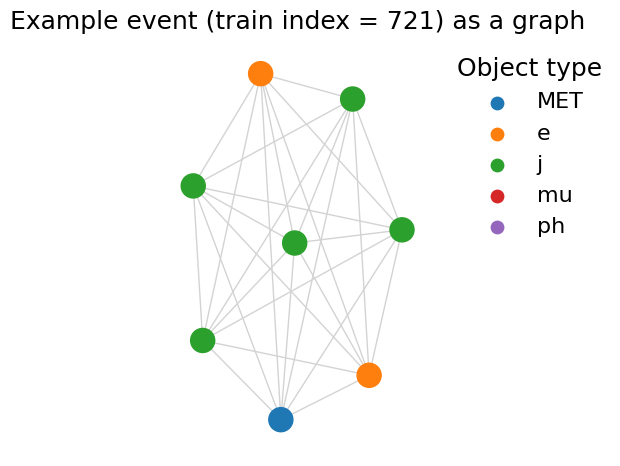

Object counts in this event:
  MET: 1
  e: 2
  j: 5


In [25]:
# Cell 3: visualise one example graph

from torch_geometric.utils import to_networkx
import networkx as nx
import matplotlib as mpl

# Safely choose an example event
example_idx = 721  # change this to look at other events, must be < len(train_graphs)
example_data = train_graphs[example_idx]

# Convert to NetworkX graph (nodes are 0 .. N-1, same order as example_data.x)
G = to_networkx(example_data, to_undirected=True)

# Deduce object type from the one-hot part of the node features (x[:, 3:])
# Uses the SAME ordering as in build_obj_df_and_pyg_dataset:
# OBJ_TYPES = ["MET", "e", "j", "mu", "ph"]
try:
    OBJ_TYPES  # use the global definition if it exists
except NameError:
    OBJ_TYPES = ["MET", "e", "j", "mu", "ph"]

x = example_data.x.cpu().numpy()          # shape [N_nodes, 8]
one_hot = x[:, 3:]                        # shape [N_nodes, 5]
obj_type_idx = one_hot.argmax(axis=1)     # integers 0..4

# Map each node to a specific color
cmap = mpl.colormaps.get_cmap("tab10")
node_colors = [cmap(i) for i in obj_type_idx]

fig, ax = plt.subplots(figsize=(5, 5))
pos = nx.spring_layout(G, seed=42)

nx.draw(
    G,
    pos,
    node_color=node_colors,
    with_labels=False,
    node_size=300,
    edge_color="lightgray",
    ax=ax,
)

# Build a matching legend
for i, name in enumerate(OBJ_TYPES):
    ax.scatter([], [], color=cmap(i), label=name, s=80)
ax.legend(title="Object type", bbox_to_anchor=(1.05, 1), loc="upper left")

ax.set_title(f"Example event (train index = {example_idx}) as a graph")
plt.tight_layout()
plt.show()

# (optional) print a quick summary of how many objects of each type are in this event
unique, counts = np.unique(obj_type_idx, return_counts=True)
print("Object counts in this event:")
for idx, cnt in zip(unique, counts):
    print(f"  {OBJ_TYPES[idx]}: {cnt}")


In [11]:
# Cell 4: define a simple GNN for event classification

from torch_geometric.nn import GCNConv, global_mean_pool
import torch.nn as nn

class EventGNN(torch.nn.Module):
    def __init__(self, in_channels=8, hidden_channels=32, num_classes=2):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.lin1  = nn.Linear(hidden_channels, hidden_channels)
        self.lin2  = nn.Linear(hidden_channels, num_classes)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch  # batch is added by DataLoader

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)

        # global pooling → [num_graphs, hidden_channels]
        x = global_mean_pool(x, batch)

        x = self.lin1(x)
        x = F.relu(x)
        x = self.lin2(x)          # logits for 2 classes

        return x

model = EventGNN(in_channels=train_graphs[0].x.size(1), hidden_channels=64, num_classes=2).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()

print(model)


EventGNN(
  (conv1): GCNConv(8, 64)
  (conv2): GCNConv(64, 64)
  (lin1): Linear(in_features=64, out_features=64, bias=True)
  (lin2): Linear(in_features=64, out_features=2, bias=True)
)


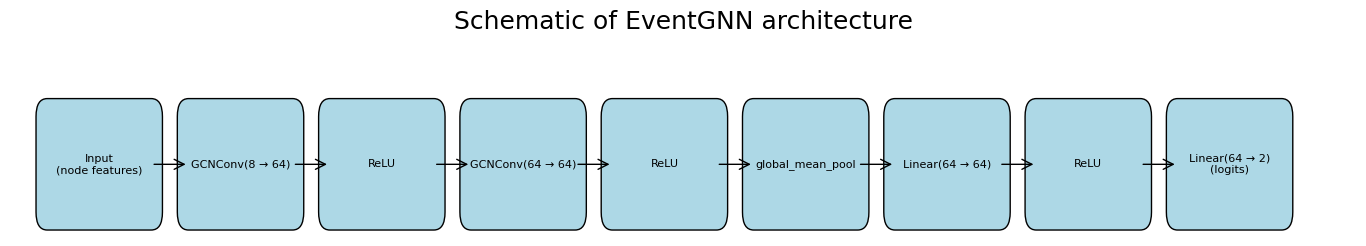

In [28]:
# Cell 5 (fixed): pictorial representation of the GNN architecture (schematic)

import matplotlib.patches as patches

layers = [
    "Input\n(node features)",
    "GCNConv(8 → 64)",
    "ReLU",
    "GCNConv(64 → 64)",
    "ReLU",
    "global_mean_pool",
    "Linear(64 → 64)",
    "ReLU",
    "Linear(64 → 2)\n(logits)",
]

n_layers   = len(layers)
box_width  = 1.4
box_height = 0.8
gap        = 0.5
x0         = 0.5   # left margin
y0         = 0.2   # bottom margin

# Figure width scales with number of layers so everything is visible
fig_width = max(12, n_layers * (box_width + gap) * 0.6)
fig, ax = plt.subplots(figsize=(fig_width+2, 2.8))
ax.axis("off")

for i, name in enumerate(layers):
    x_left = x0 + i * (box_width + gap)

    rect = patches.FancyBboxPatch(
        (x_left, y0),
        box_width,
        box_height,
        boxstyle="round,pad=0.15",
        edgecolor="black",
        facecolor="lightblue",
    )
    ax.add_patch(rect)

    ax.text(
        x_left + box_width / 2.0,
        y0 + box_height / 2.0,
        name,
        ha="center",
        va="center",
        fontsize=8,
    )

    # Draw arrows between blocks
    if i < n_layers - 1:
        x_start = x_left + box_width
        x_end   = x0 + (i + 1) * (box_width + gap)
        ax.annotate(
            "",
            xy=(x_end, y0 + box_height / 2.0),
            xytext=(x_start, y0 + box_height / 2.0),
            arrowprops=dict(arrowstyle="->"),
        )

# Make sure everything is in view
x_max = x0 + n_layers * (box_width + gap)
ax.set_xlim(0, x_max + 0.5)
ax.set_ylim(0, y0 + box_height + 0.5)

plt.title("Schematic of EventGNN architecture", pad=20)
plt.tight_layout()
plt.show()


Should take appoximately 17 mins to train 20 epochs

In [12]:
# Cell 6: training & validation loop

from torch_geometric.loader import DataLoader

num_epochs = 10

train_losses = []
val_losses   = []
val_accuracies = []

for epoch in range(1, num_epochs + 1):
    # --- Training ---
    model.train()
    total_loss = 0.0

    for batch in train_loader:
        batch = batch.to(device)
        optimizer.zero_grad()
        out = model(batch)                # [batch_size_graphs, 2]
        loss = criterion(out, batch.y)    # batch.y shape [batch_size_graphs]
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * batch.num_graphs

    avg_train_loss = total_loss / len(train_graphs)
    train_losses.append(avg_train_loss)

    # --- Validation ---
    model.eval()
    total_val_loss = 0.0
    correct = 0

    with torch.no_grad():
        for batch in val_loader:
            batch = batch.to(device)
            out = model(batch)
            loss = criterion(out, batch.y)
            total_val_loss += loss.item() * batch.num_graphs

            preds = out.argmax(dim=1)
            correct += (preds == batch.y).sum().item()

    avg_val_loss = total_val_loss / len(val_graphs)
    val_losses.append(avg_val_loss)

    val_acc = correct / len(val_graphs)
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch:02d} | "
          f"Train loss: {avg_train_loss:.4f} | "
          f"Val loss: {avg_val_loss:.4f} | "
          f"Val acc: {val_acc:.3f}")


Epoch 01 | Train loss: 0.2843 | Val loss: 0.2681 | Val acc: 0.888
Epoch 02 | Train loss: 0.2720 | Val loss: 0.2672 | Val acc: 0.889
Epoch 03 | Train loss: 0.2701 | Val loss: 0.2668 | Val acc: 0.889
Epoch 04 | Train loss: 0.2692 | Val loss: 0.2658 | Val acc: 0.889
Epoch 05 | Train loss: 0.2683 | Val loss: 0.2659 | Val acc: 0.889
Epoch 06 | Train loss: 0.2676 | Val loss: 0.2652 | Val acc: 0.889
Epoch 07 | Train loss: 0.2673 | Val loss: 0.2660 | Val acc: 0.889
Epoch 08 | Train loss: 0.2671 | Val loss: 0.2666 | Val acc: 0.889
Epoch 09 | Train loss: 0.2668 | Val loss: 0.2645 | Val acc: 0.890
Epoch 10 | Train loss: 0.2668 | Val loss: 0.2657 | Val acc: 0.890


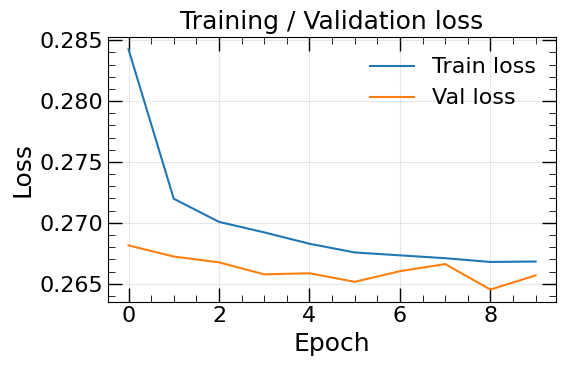

In [13]:
# Cell 7: training & validation loss curves

plt.figure(figsize=(6, 4))
plt.plot(train_losses, label="Train loss")
plt.plot(val_losses,   label="Val loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training / Validation loss")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


Test accuracy: 0.889
AUC: 0.958


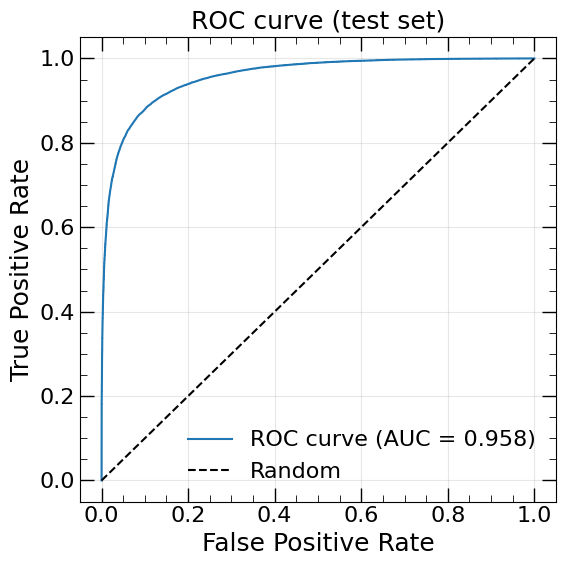

In [14]:
# Cell 8: evaluation on test set and ROC curve

model.eval()
all_probs = []
all_labels = []

with torch.no_grad():
    for batch in test_loader:
        batch = batch.to(device)
        logits = model(batch)                      # [B, 2]
        probs = F.softmax(logits, dim=1)[:, 1]     # probability of class 1 (signal)
        all_probs.append(probs.cpu())
        all_labels.append(batch.y.cpu())

all_probs = torch.cat(all_probs).numpy()
all_labels = torch.cat(all_labels).numpy()

# Basic accuracy
pred_labels = (all_probs >= 0.5).astype(int)
test_acc = (pred_labels == all_labels).mean()
print(f"Test accuracy: {test_acc:.3f}")

# ROC curve
fpr, tpr, thresholds = roc_curve(all_labels, all_probs)
roc_auc = auc(fpr, tpr)
print(f"AUC: {roc_auc:.3f}")

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.3f})")
plt.plot([0, 1], [0, 1], "k--", label="Random")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curve (test set)")
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


## GNN: Unsupervised Anomaly Detection

Run the cell for `build_obj_df_and_pyg_dataset(df)` in the previous section.

In [15]:
# Cell 1: build PyG graphs and split background vs signal

import torch
from torch_geometric.loader import DataLoader

df = ML_dict["all_signals"]

# Uses the previously defined function (EB_test -> 0, signal -> 1)
obj_df, pyg_list = build_obj_df_and_pyg_dataset(df)

print(f"Total events (graphs): {len(pyg_list)}")
print("Labels (0=EB_test/background, 1=signal):",
      {int(y): int(sum(g.y.item() == y for g in pyg_list)) for y in [0,1]})

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Extract labels
labels = np.array([g.y.item() for g in pyg_list])
bkg_idx    = np.where(labels == 0)[0]   # EB_test
signal_idx = np.where(labels == 1)[0]   # everything else
print(f"Background graphs: {len(bkg_idx)}, Signal graphs: {len(signal_idx)}")


Total events (graphs): 604611
Labels (0=EB_test/background, 1=signal): {0: 286955, 1: 317656}
Using device: cuda
Background graphs: 286955, Signal graphs: 317656


In [16]:
# Cell 2: make train/val/test splits (background-only training)

from sklearn.model_selection import train_test_split

# 1) Split background into train+val and test (e.g. 80/20)
bkg_trainval_idx, bkg_test_idx = train_test_split(
    bkg_idx,
    test_size=0.2,
    random_state=42,
)

# 2) Split train+val into train and val (e.g. 80/20 of the bkg_trainval set)
bkg_train_idx, bkg_val_idx = train_test_split(
    bkg_trainval_idx,
    test_size=0.2,
    random_state=42,
)

print(f"Background train: {len(bkg_train_idx)}, "
      f"val: {len(bkg_val_idx)}, test: {len(bkg_test_idx)}")

# Build graph lists
train_graphs = [pyg_list[i] for i in bkg_train_idx]        # background only
val_graphs   = [pyg_list[i] for i in bkg_val_idx]          # background only
# Test set: held-out background + ALL signal
test_idx     = np.concatenate([bkg_test_idx, signal_idx])
test_graphs  = [pyg_list[i] for i in test_idx]
test_labels  = labels[test_idx]   # 0 for bkg, 1 for signal

print(f"Train graphs: {len(train_graphs)}, "
      f"Val graphs: {len(val_graphs)}, "
      f"Test graphs: {len(test_graphs)}")

batch_size = 64

train_loader = DataLoader(train_graphs, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_graphs,   batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_graphs,  batch_size=batch_size, shuffle=False)


Background train: 183651, val: 45913, test: 57391
Train graphs: 183651, Val graphs: 45913, Test graphs: 375047


In [17]:
# Cell 3: define deeper Graph Autoencoder (node-wise)

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

class GraphAutoEncoder(nn.Module):
    def __init__(
        self,
        in_channels=8,
        hidden_channels1=64,
        hidden_channels2=32,
        latent_channels=16,   # thinner bottleneck
    ):
        super().__init__()

        # ----- Encoder GNN: 3 layers -----
        self.conv1 = GCNConv(in_channels,    hidden_channels1)          #
        self.conv2 = GCNConv(hidden_channels1, hidden_channels2)
        self.conv3 = GCNConv(hidden_channels2, latent_channels)

        # ----- Decoder MLP: 3 layers (rough mirror) -----
        self.dec_lin1 = nn.Linear(latent_channels, hidden_channels2)        #
        self.dec_lin2 = nn.Linear(hidden_channels2, hidden_channels1)
        self.dec_lin3 = nn.Linear(hidden_channels1, in_channels)

    def encode(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = self.conv3(x, edge_index)
        z = F.relu(x)           # latent node embeddings
        return z

    def decode(self, z):
        x_hat = F.relu(self.dec_lin1(z))
        x_hat = F.relu(self.dec_lin2(x_hat))
        x_hat = self.dec_lin3(x_hat)
        return x_hat

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        z = self.encode(x, edge_index)
        x_hat = self.decode(z)
        return x_hat, z


In [18]:
# Cell 3: define shallow Graph Autoencoder (node-wise)

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

class GraphAutoEncoder(nn.Module):
    def __init__(
        self,
        in_channels=8,
        hidden_channels1=64,
        hidden_channels2=32,
        latent_channels=4,
    ):
        super().__init__()

        # ----- Encoder GNN: 1 layer -----
        self.conv1 = GCNConv(in_channels, latent_channels)

        # ----- Decoder MLP: 1 layer (rough mirror) -----
        self.dec_lin1 = nn.Linear(latent_channels, in_channels)

    def encode(self, x, edge_index):
        x = self.conv1(x, edge_index)
        z = F.relu(x)           # latent node embeddings
        return z

    def decode(self, z):
        x_hat = self.dec_lin1(z)
        return x_hat

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        z = self.encode(x, edge_index)
        x_hat = self.decode(z)
        return x_hat, z


In [19]:
# Cell 4: hyperparameters, model, optimizer, loaders

from torch_geometric.loader import DataLoader

# ---- Hyperparameters to tune ----
hidden_channels1 = 128
hidden_channels2 = 64
latent_channels  = 4

lr           = 1e-3
weight_decay = 1e-4
batch_size   = 100
num_epochs   = 10

# ---- DataLoaders ----
train_loader = DataLoader(train_graphs, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_graphs,   batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_graphs,  batch_size=batch_size, shuffle=False)

# ---- Model & optimizer ----
in_dim = train_graphs[0].x.size(1)

model = GraphAutoEncoder(
    in_channels=in_dim,
    hidden_channels1=hidden_channels1,
    hidden_channels2=hidden_channels2,
    latent_channels=latent_channels,
).to(device)

optimizer = torch.optim.Adam(
    model.parameters(),
    lr=lr,
    weight_decay=weight_decay,
)
recon_loss_fn = nn.MSELoss()

print(model)


GraphAutoEncoder(
  (conv1): GCNConv(8, 4)
  (dec_lin1): Linear(in_features=4, out_features=8, bias=True)
)


Approximately 10 mins

In [20]:
# Cell 5: training loop (background-only, reconstruction loss)

train_losses = []
val_losses   = []

for epoch in range(1, num_epochs + 1):
    # ----- Training -----
    model.train()
    total_train_loss = 0.0
    total_nodes_train = 0

    for batch in train_loader:
        batch = batch.to(device)
        optimizer.zero_grad()

        x_hat, z = model(batch)
        loss = recon_loss_fn(x_hat, batch.x)

        loss.backward()
        optimizer.step()

        total_train_loss += loss.item() * batch.num_nodes
        total_nodes_train += batch.num_nodes

    avg_train_loss = total_train_loss / max(total_nodes_train, 1)
    train_losses.append(avg_train_loss)

    # ----- Validation -----
    model.eval()
    total_val_loss = 0.0
    total_nodes_val = 0

    with torch.no_grad():
        for batch in val_loader:
            batch = batch.to(device)
            x_hat, z = model(batch)
            loss = recon_loss_fn(x_hat, batch.x)

            total_val_loss += loss.item() * batch.num_nodes
            total_nodes_val += batch.num_nodes

    avg_val_loss = total_val_loss / max(total_nodes_val, 1)
    val_losses.append(avg_val_loss)

    print(f"Epoch {epoch:02d} | "
          f"Train recon loss: {avg_train_loss:.6f} | "
          f"Val recon loss: {avg_val_loss:.6f}")


Epoch 01 | Train recon loss: 13.501414 | Val recon loss: 9.758409
Epoch 02 | Train recon loss: 10.897472 | Val recon loss: 9.741844
Epoch 03 | Train recon loss: 10.884399 | Val recon loss: 9.734812
Epoch 04 | Train recon loss: 10.880123 | Val recon loss: 9.732956
Epoch 05 | Train recon loss: 10.879206 | Val recon loss: 9.732454
Epoch 06 | Train recon loss: 10.878871 | Val recon loss: 9.732409
Epoch 07 | Train recon loss: 10.878638 | Val recon loss: 9.731950
Epoch 08 | Train recon loss: 10.878256 | Val recon loss: 9.731237
Epoch 09 | Train recon loss: 10.876839 | Val recon loss: 9.728956
Epoch 10 | Train recon loss: 10.874858 | Val recon loss: 9.727863


Approximately 2 mins


ROC–AUC (anomaly detection): 0.9028
Experiment folder: gae_experiments/exp_20251125_152816
Saved hyperparameters and ROC–AUC to: gae_experiments/exp_20251125_152816/hyperparams_and_metrics.txt


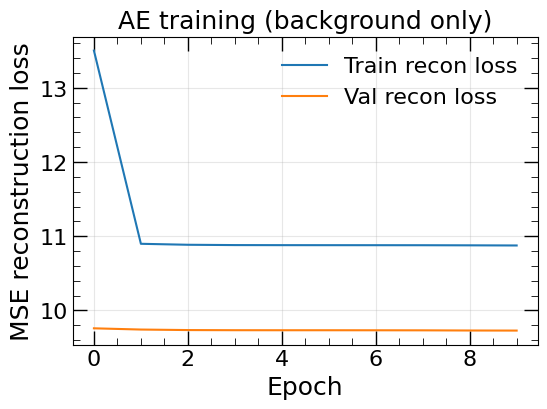

Saved reconstruction loss plot to: gae_experiments/exp_20251125_152816/recon_loss.png


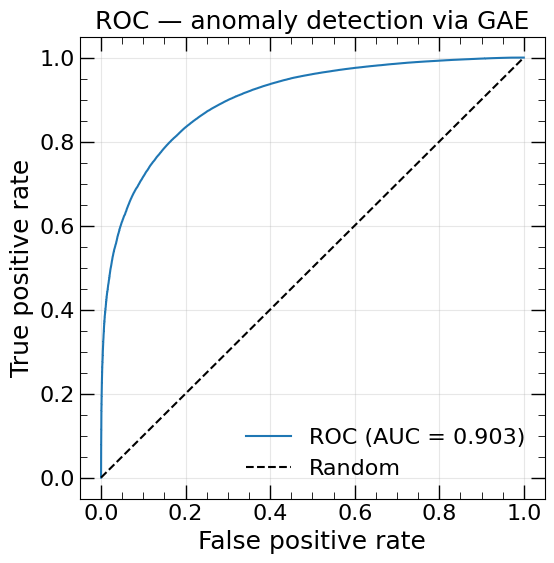

Saved ROC curve to: gae_experiments/exp_20251125_152816/roc_curve.png


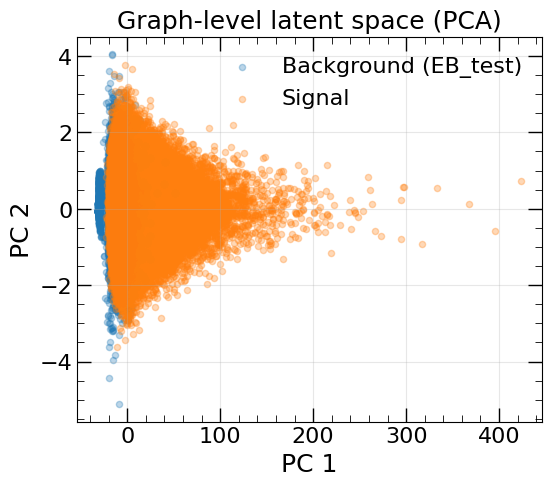

Saved latent space plot to: gae_experiments/exp_20251125_152816/latent_space_pca.png


In [21]:
# Cell 6: evaluation, experiment folder, saving plots & hyperparams

import os
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from torch_geometric.nn import global_mean_pool
from sklearn.decomposition import PCA

# ----- 1) Compute anomaly scores (reconstruction errors) on test set -----
model.eval()
graph_errors = []
graph_labels = []

with torch.no_grad():
    for batch in test_loader:
        batch = batch.to(device)
        x_hat, z = model(batch)

        # per-node MSE across all features
        per_node_err = ((x_hat - batch.x) ** 2).mean(dim=1)  # [num_nodes]

        # aggregate to per-graph using batch.batch
        for g in range(batch.num_graphs):
            mask = (batch.batch == g)
            err_g = per_node_err[mask].mean().item()
            graph_errors.append(err_g)

        graph_labels.extend(batch.y.cpu().numpy().tolist())

graph_errors = np.array(graph_errors)
graph_labels = np.array(graph_labels)

# ROC–AUC
fpr, tpr, thresholds = roc_curve(graph_labels, graph_errors)
roc_auc = auc(fpr, tpr)
print(f"\nROC–AUC (anomaly detection): {roc_auc:.4f}")

# ----- 2) Create new experiment folder -----
exp_root = "gae_experiments"
os.makedirs(exp_root, exist_ok=True)

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
exp_dir = os.path.join(exp_root, f"exp_{timestamp}")
os.makedirs(exp_dir, exist_ok=True)

print("Experiment folder:", exp_dir)

# ----- 3) Save hyperparameters + ROC–AUC in a .txt file -----
txt_path = os.path.join(exp_dir, "hyperparams_and_metrics.txt")
with open(txt_path, "w") as f:
    f.write("Graph Autoencoder experiment\n")
    f.write(f"Timestamp           : {timestamp}\n")
    f.write("\nModel hyperparameters:\n")
    f.write(f"  in_channels       : {in_dim}\n")
    f.write(f"  hidden_channels1  : {hidden_channels1}\n")
    f.write(f"  hidden_channels2  : {hidden_channels2}\n")
    f.write(f"  latent_channels   : {latent_channels}\n")
    f.write("\nTraining hyperparameters:\n")
    f.write(f"  lr                : {lr}\n")
    f.write(f"  weight_decay      : {weight_decay}\n")
    f.write(f"  batch_size        : {batch_size}\n")
    f.write(f"  num_epochs        : {num_epochs}\n")
    f.write("\nResults:\n")
    f.write(f"  ROC_AUC           : {roc_auc:.6f}\n")

print("Saved hyperparameters and ROC–AUC to:", txt_path)

# ----- 4) Save reconstruction loss curves -----
plt.figure(figsize=(6, 4))
plt.plot(train_losses, label="Train recon loss")
plt.plot(val_losses,   label="Val recon loss")
plt.xlabel("Epoch")
plt.ylabel("MSE reconstruction loss")
plt.title("AE training (background only)")
plt.legend()
plt.grid(True, alpha=0.3)
recon_loss_path = os.path.join(exp_dir, "recon_loss.png")
plt.savefig(recon_loss_path, dpi=150)
plt.show()
print("Saved reconstruction loss plot to:", recon_loss_path)

# ----- 5) Save ROC curve -----
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label=f"ROC (AUC = {roc_auc:.3f})")
plt.plot([0, 1], [0, 1], "k--", label="Random")
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.title("ROC — anomaly detection via GAE")
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
roc_path = os.path.join(exp_dir, "roc_curve.png")
plt.savefig(roc_path, dpi=150)
plt.show()
print("Saved ROC curve to:", roc_path)

# ----- 6) Compute & save latent space visualisation (graph-level) -----

# Get graph-level latent embeddings for test graphs
latent_graphs = []
latent_labels = []

with torch.no_grad():
    for batch in test_loader:
        batch = batch.to(device)
        x_hat, z = model(batch)  # z: [num_nodes, latent_channels]
        # pool node embeddings to graph embeddings
        g_emb = global_mean_pool(z, batch.batch)  # [num_graphs, latent_channels]
        latent_graphs.append(g_emb.cpu().numpy())
        latent_labels.append(batch.y.cpu().numpy())

latent_graphs = np.concatenate(latent_graphs, axis=0)  # [N_test, latent_channels]
latent_labels = np.concatenate(latent_labels, axis=0)  # [N_test]

# PCA to 2D for visualisation
pca = PCA(n_components=2)
latent_2d = pca.fit_transform(latent_graphs)

bkg_mask    = (latent_labels == 0)
signal_mask = (latent_labels == 1)

plt.figure(figsize=(6, 5))
plt.scatter(
    latent_2d[bkg_mask, 0],
    latent_2d[bkg_mask, 1],
    alpha=0.3, s=20, label="Background (EB_test)"
)
plt.scatter(
    latent_2d[signal_mask, 0],
    latent_2d[signal_mask, 1],
    alpha=0.3, s=20, label="Signal"
)
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.title("Graph-level latent space (PCA)")
plt.legend()
plt.grid(True, alpha=0.3)
latent_path = os.path.join(exp_dir, "latent_space_pca.png")
plt.savefig(latent_path, dpi=150)
plt.show()
print("Saved latent space plot to:", latent_path)


Calculated reconstruction errors for 375047 test samples.


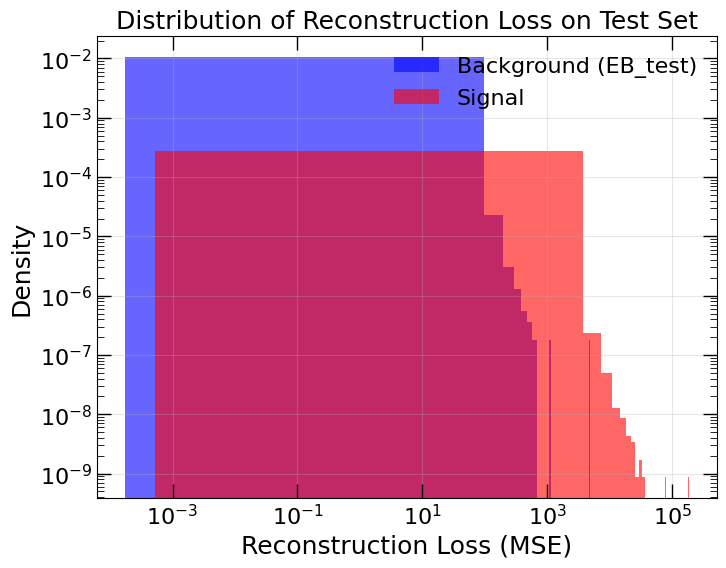

In [22]:
# Ensure `model` is in evaluation mode
model.eval()

# Initialize lists to store reconstruction errors and labels
recon_errors = []
true_labels = []

# Assuming test_loader and test_labels are available from previous cells
# If this is a new notebook, you would need to recreate test_loader and test_labels

with torch.no_grad():
    for batch in test_loader:
        batch = batch.to(device)
        x_hat, z = model(batch)

        # Per-node MSE across all features
        per_node_err = ((x_hat - batch.x) ** 2).mean(dim=1)  # [num_nodes]

        # Aggregate to per-graph using batch.batch
        for g in range(batch.num_graphs):
            mask = (batch.batch == g)
            err_g = per_node_err[mask].mean().item()
            recon_errors.append(err_g)

        true_labels.extend(batch.y.cpu().numpy().tolist())

recon_errors = np.array(recon_errors)
true_labels = np.array(true_labels)

print(f"Calculated reconstruction errors for {len(recon_errors)} test samples.")

# Separate errors for background and signal
bkg_errors = recon_errors[true_labels == 0]
sig_errors = recon_errors[true_labels == 1]

# Plotting the distribution of reconstruction errors
plt.figure(figsize=(8, 6))
plt.hist(bkg_errors, bins=50, density=True, alpha=0.6, label="Background (EB_test)", color='blue')
plt.hist(sig_errors, bins=50, density=True, alpha=0.6, label="Signal", color='red')

plt.xlabel("Reconstruction Loss (MSE)")
plt.ylabel("Density")
plt.title("Distribution of Reconstruction Loss on Test Set")
plt.legend()
plt.grid(True, alpha=0.3)
plt.xscale('log')
plt.yscale('log')
plt.show()


In [ ]:
import torch
import os

# Ensure exp_dir is defined from the previous cell if not already
# (though it should be if the previous cells ran in order)
# If running this cell independently, exp_dir might need to be re-initialized
# For this interactive context, we assume ZzWUJawJI_KO has been executed.

# Save the model's state dictionary
model_save_path = os.path.join(exp_dir, "gae_model_state_dict.pth")
torch.save(model.state_dict(), model_save_path)

print(f"Model state dictionary saved to: {model_save_path}")

Model state dictionary saved to: gae_experiments/exp_20251125_100949/gae_model_state_dict.pth


**To load the model in a different notebook:**

```
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
import os

# --- Step 1: Mount Google Drive (if your model is saved there) ---
# This is necessary if your model is in MyDrive. Skip if not applicable.
from google.colab import drive
drive.mount('/content/drive')

# --- Step 2: Re-define the GraphAutoEncoder class (EXACTLY as it was trained) ---
# This class definition must match the one from cell TgGOtSB2GnKe when the model was trained.
class GraphAutoEncoder(nn.Module):
    def __init__(
        self,
        in_channels=8,
        hidden_channels1=64, # These parameters are part of the __init__ signature
        hidden_channels2=32, # but were not used in the 'shallow' model's layers.
        latent_channels=16,
    ):
        super().__init__()

        # --- Encoder GNN: 1 layer ---
        self.conv1 = GCNConv(in_channels, latent_channels)

        # --- Decoder MLP: 1 layer ---
        self.dec_lin1 = nn.Linear(latent_channels, in_channels)

    def encode(self, x, edge_index):
        x = self.conv1(x, edge_index)
        z = F.relu(x)  # Latent node embeddings
        return z

    def decode(self, z):
        x_hat = self.dec_lin1(z)
        return x_hat

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        z = self.encode(x, edge_index)
        x_hat = self.decode(z)
        return x_hat, z

# Define the device (GPU if available, else CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- Step 3: Instantiate the model with the EXACT parameters used during training ---
# These values must match those found in cell `5mQeb_tVI3dq` of the training notebook.
TRAINING_IN_CHANNELS = 8
TRAINING_HIDDEN_CHANNELS1 = 128
TRAINING_HIDDEN_CHANNELS2 = 64
TRAINING_LATENT_CHANNELS = 4

loaded_model = GraphAutoEncoder(
    in_channels=TRAINING_IN_CHANNELS,
    hidden_channels1=TRAINING_HIDDEN_CHANNELS1,
    hidden_channels2=TRAINING_HIDDEN_CHANNELS2,
    latent_channels=TRAINING_LATENT_CHANNELS,
).to(device)

# --- Step 4: Define the path to your saved model file ---
# IMPORTANT: You MUST update this path to where YOUR model is saved.
# The example path below uses the last saved path from this notebook.
model_save_path = "/content/drive/MyDrive/gae_experiments/exp_20251125_100949/gae_model_state_dict.pth"

# --- Step 5 & 6: Load the state dictionary and set to evaluation mode ---
if not os.path.exists(model_save_path):
    print(f"Error: Model file not found at {model_save_path}")
    print("Please ensure Google Drive is mounted and the path is correct.")
else:
    # Load the state dictionary, mapping to the current device
    loaded_state_dict = torch.load(model_save_path, map_location=device)

    # Apply the loaded state dictionary to the model
    loaded_model.load_state_dict(loaded_state_dict)

    # Set the model to evaluation mode (important for inference)
    loaded_model.eval()

    print(f"Model successfully loaded from: {model_save_path}")
    print("Loaded Model Architecture:")
    print(loaded_model)

    # You can now use `loaded_model` for predictions in your new notebook.
```



## GNN: Unsupervised Anomaly Detection (with jet $p_T$ threshold scan)
This section trains a Graph Autoencoder (GAE) on EB\_test (background) only, and
evaluates anomaly detection performance (signal vs background) for different
jet $p_T$ thresholds, analogous to the Random Forest scan.


In [8]:
# === Config for GNN: Unsupervised Anomaly Detection + pT scan ===

import os
import json
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
from sklearn.decomposition import PCA

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch_geometric.loader import DataLoader
from torch_geometric.nn import GCNConv, global_mean_pool

# UMAP is optional – we'll only use it if available
try:
    import umap
    HAS_UMAP = True
except ImportError:
    HAS_UMAP = False
    print("Warning: umap-learn not installed; UMAP plots will skip UMAP.")

# ------------------------------------------------------------------
# Jet pT thresholds & selection, reusing RF config if available
# ------------------------------------------------------------------
try:
    JET_PT_THRESHOLDS
    JET_PT_COLS
except NameError:
    # Fallback if RF section hasn't run
    JET_PT_THRESHOLDS = [5, 15, 25, 45, 60, 80]
    JET_PT_COLS = [f"j{i}pt" for i in range(6)]

if "apply_jet_pt_threshold" not in globals():
    def apply_jet_pt_threshold(df, threshold):
        """
        Returns a filtered dataframe where all nonzero jets have pt >= threshold.
        Condition: for each jet jX,
          keep event if (jXpt == 0) or (jXpt >= threshold)
        """
        mask = np.ones(len(df), dtype=bool)
        for col in JET_PT_COLS:
            if col in df.columns:
                mask &= (df[col] == 0) | (df[col] >= threshold)
        return df[mask]

# ------------------------------------------------------------------
# Device & base directory for GNN unsupervised experiments
# ------------------------------------------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("GNN (unsupervised) will run on:", device)

if "PLOT_BASE_DIR" not in globals():
    PLOT_BASE_DIR = "/content/drive/MyDrive/Datasets/plots"

GNN_UNSUP_BASE_DIR = os.path.join(PLOT_BASE_DIR, "GNN_unsupervised")
os.makedirs(GNN_UNSUP_BASE_DIR, exist_ok=True)

print("GNN unsupervised results will be saved under:", GNN_UNSUP_BASE_DIR)


GNN (unsupervised) will run on: cpu
GNN unsupervised results will be saved under: /content/drive/MyDrive/Datasets/plots/GNN_unsupervised


In [9]:
# === Helper classes & functions for GAE unsupervised anomaly detection ===

class GraphAutoEncoder(nn.Module):
    """
    Simple node-wise Graph Autoencoder:
      Encoder:  GCNConv -> ReLU -> GCNConv -> ReLU
      Decoder:  Linear -> ReLU -> Linear
    Operates on node features [pT, eta, phi, 5-dim one-hot] => in_channels=8.
    """
    def __init__(self, in_channels=8, hidden_channels=64, latent_channels=16, dropout=0.1):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, latent_channels)
        self.dropout = dropout

        self.dec_lin1 = nn.Linear(latent_channels, hidden_channels)
        self.dec_lin2 = nn.Linear(hidden_channels, in_channels)

    def encode(self, x, edge_index):
        h = self.conv1(x, edge_index)
        h = F.relu(h)
        h = F.dropout(h, p=self.dropout, training=self.training)
        z = self.conv2(h, edge_index)
        z = F.relu(z)
        return z

    def decode(self, z):
        h = self.dec_lin1(z)
        h = F.relu(h)
        h = F.dropout(h, p=self.dropout, training=self.training)
        x_hat = self.dec_lin2(h)
        return x_hat

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        z = self.encode(x, edge_index)
        x_hat = self.decode(z)
        return x_hat, z


def make_gae_splits_and_loaders(
    pyg_list,
    labels,
    batch_size=128,
    random_state=42,
):
    """
    Make background-only train/val, and background+signal test set.
    labels: numpy array of shape [n_graphs] with 0 (bkg) and 1 (signal).
    """
    labels = np.asarray(labels)
    bkg_idx = np.where(labels == 0)[0]
    sig_idx = np.where(labels == 1)[0]

    # 80/20 split of background into train+val and test
    bkg_trainval_idx, bkg_test_idx = train_test_split(
        bkg_idx,
        test_size=0.2,
        random_state=random_state,
    )

    # 80/20 of the trainval background into train and val
    bkg_train_idx, bkg_val_idx = train_test_split(
        bkg_trainval_idx,
        test_size=0.2,
        random_state=random_state,
    )

    train_graphs = [pyg_list[i] for i in bkg_train_idx]
    val_graphs   = [pyg_list[i] for i in bkg_val_idx]

    # Test: held-out background + *all* signal
    test_idx    = np.concatenate([bkg_test_idx, sig_idx])
    test_graphs = [pyg_list[i] for i in test_idx]
    test_labels = labels[test_idx]

    train_loader = DataLoader(train_graphs, batch_size=batch_size, shuffle=True)
    val_loader   = DataLoader(val_graphs,   batch_size=batch_size, shuffle=False)
    test_loader  = DataLoader(test_graphs,  batch_size=batch_size, shuffle=False)

    split_counts = {
        "n_train_bkg": len(train_graphs),
        "n_val_bkg":   len(val_graphs),
        "n_test_bkg":  len(bkg_test_idx),
        "n_test_sig":  len(sig_idx),
    }

    return train_loader, val_loader, test_loader, test_labels, split_counts


def train_gae(
    model,
    train_loader,
    val_loader,
    device,
    num_epochs=20,
    lr=1e-3,
    weight_decay=1e-5,
    verbose=True,
):
    """
    Train the GAE on background-only graphs using node-wise MSE loss.
    Returns training history and best validation loss.
    """
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    best_val_loss = float("inf")
    best_state_dict = None

    history = {"train": [], "val": []}

    for epoch in range(1, num_epochs + 1):
        # ---- training ----
        model.train()
        train_loss = 0.0
        n_train_batches = 0

        for batch in train_loader:
            batch = batch.to(device)
            optimizer.zero_grad()

            x_hat, z = model(batch)
            loss = F.mse_loss(x_hat, batch.x)

            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            n_train_batches += 1

        train_loss /= max(n_train_batches, 1)

        # ---- validation ----
        model.eval()
        val_loss = 0.0
        n_val_batches = 0

        with torch.no_grad():
            for batch in val_loader:
                batch = batch.to(device)

                x_hat, z = model(batch)
                loss = F.mse_loss(x_hat, batch.x)

                val_loss += loss.item()
                n_val_batches += 1

        val_loss /= max(n_val_batches, 1)

        history["train"].append(train_loss)
        history["val"].append(val_loss)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            # store best weights on CPU to avoid issues when saving
            best_state_dict = {k: v.cpu() for k, v in model.state_dict().items()}

        if verbose and (epoch == 1 or epoch % 5 == 0 or epoch == num_epochs):
            print(f"Epoch {epoch:03d}/{num_epochs} | train={train_loss:.4e} | val={val_loss:.4e}")

    if best_state_dict is not None:
        model.load_state_dict(best_state_dict)

    return history, best_val_loss


def compute_anomaly_scores_and_latents(model, loader, device):
    """
    Compute graph-level anomaly scores and latent embeddings.

    - score = mean node-wise reconstruction error per graph
    - latent = mean of node latent vectors per graph
    """
    model.eval()
    all_scores = []
    all_latent = []

    with torch.no_grad():
        for batch in loader:
            batch = batch.to(device)
            x_hat, z = model(batch)

            # per-element squared error, then mean over features -> per-node error
            per_element = F.mse_loss(x_hat, batch.x, reduction="none")   # [N_nodes, in_channels]
            per_node    = per_element.mean(dim=1)                         # [N_nodes]

            # graph-level mean error and latent using global_mean_pool
            graph_scores = global_mean_pool(per_node, batch.batch)        # [n_graphs_in_batch]
            graph_latent = global_mean_pool(z,         batch.batch)       # [n_graphs_in_batch, latent_dim]

            all_scores.append(graph_scores.cpu().numpy())
            all_latent.append(graph_latent.cpu().numpy())

    scores = np.concatenate(all_scores, axis=0)
    latent = np.concatenate(all_latent, axis=0)

    return scores, latent


def compute_roc_auc(scores, labels):
    """
    Compute ROC curve and AUC for anomaly scores.
    Assumes larger scores = more anomalous (signal-like).
    """
    fpr, tpr, _ = roc_curve(labels, scores)
    roc_auc = auc(fpr, tpr)
    return fpr, tpr, roc_auc


# -------------------------- plotting helpers --------------------------

def plot_gae_loss_curves(history, pt_threshold, exp_dir):
    epochs = np.arange(1, len(history["train"]) + 1)

    plt.figure()
    plt.plot(epochs, history["train"], label="Train")
    plt.plot(epochs, history["val"],   label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("MSE loss")
    plt.title(f"GAE training curves (T = {pt_threshold} GeV)")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(os.path.join(exp_dir, f"loss_curves_T{pt_threshold}.png"))
    plt.close()


def plot_anomaly_score_distribution(scores, labels, pt_threshold, exp_dir):
    scores = np.asarray(scores)
    labels = np.asarray(labels)

    bkg_scores = scores[labels == 0]
    sig_scores = scores[labels == 1]

    if len(scores) == 0:
        return

    # Use central percentile range to avoid extreme tails dominating the histogram range
    lo = np.percentile(scores, 1)
    hi = np.percentile(scores, 99)
    if hi <= lo:
        lo, hi = scores.min(), scores.max()

    bins = np.linspace(lo, hi, 40)

    plt.figure()
    plt.hist(bkg_scores, bins=bins, histtype="step", density=True, label="Background (EB_test)")
    plt.hist(sig_scores, bins=bins, histtype="step", density=True, label="Signal (others)")
    plt.xlabel("Graph-level reconstruction error")
    plt.ylabel("Density")
    plt.title(f"Anomaly score distribution (T = {pt_threshold} GeV)")
    plt.legend()
    plt.xlim(None, 250)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(os.path.join(exp_dir, f"score_dist_T{pt_threshold}.png"))
    plt.close()


def plot_latent_space(latent, labels, pt_threshold, exp_dir):
    """
    PCA + optional UMAP of graph-level latent embeddings.
    """
    latent = np.asarray(latent)
    labels = np.asarray(labels)

    # --- PCA ---
    pca = PCA(n_components=2)
    z_pca = pca.fit_transform(latent)

    plt.figure()
    for cls, name, marker in [(0, "Background", "."), (1, "Signal", "^")]:
        mask = labels == cls
        if mask.sum() == 0:
            continue
        plt.scatter(
            z_pca[mask, 0],
            z_pca[mask, 1],
            s=10 if cls == 0 else 20,
            marker=marker,
            alpha=0.5,
            label=name,
        )
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.title(f"Latent space PCA (T = {pt_threshold} GeV)")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(os.path.join(exp_dir, f"latent_pca_T{pt_threshold}.png"), dpi=130)
    plt.close()

    # --- UMAP (optional) ---
    # if HAS_UMAP:
    #     reducer = umap.UMAP(n_components=2, random_state=42)
    #     z_umap = reducer.fit_transform(latent)

    #     plt.figure()
    #     for cls, name, marker in [(0, "Background", "."), (1, "Signal", "^")]:
    #         mask = labels == cls
    #         if mask.sum() == 0:
    #             continue
    #         plt.scatter(
    #             z_umap[mask, 0],
    #             z_umap[mask, 1],
    #             s=10 if cls == 0 else 20,
    #             marker=marker,
    #             alpha=0.5,
    #             label=name,
    #         )
    #     plt.xlabel("UMAP1")
    #     plt.ylabel("UMAP2")
    #     plt.title(f"Latent space UMAP (T = {pt_threshold} GeV)")
    #     plt.legend()
    #     plt.grid(True, alpha=0.3)
    #     plt.tight_layout()
    #     plt.savefig(os.path.join(exp_dir, f"latent_umap_T{pt_threshold}.png"), dpi=200)
    #     plt.close()


def plot_gae_roc_curves(roc_results, dataset_name, save_dir):
    """
    Multi-threshold ROC plot: one curve per jet pT threshold.
    """
    plt.figure()
    for T, (fpr, tpr, roc_auc) in roc_results.items():
        plt.plot(fpr, tpr, label=f"T={T} GeV (AUC={roc_auc:.3f})")

    plt.plot([0, 1], [0, 1], "k--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"GAE anomaly ROC — {dataset_name}")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, "gae_roc_all_thresholds.png"), dpi=130)
    plt.close()


def plot_gae_auc_vs_threshold(roc_results, dataset_name, save_dir):
    """
    AUC vs jet pT threshold, analogous to RF plot.
    """
    thresholds = sorted(roc_results.keys())
    auc_vals = [roc_results[T][2] for T in thresholds]

    plt.figure()
    plt.plot(thresholds, auc_vals, marker="o")
    plt.xlabel("Jet $p_T$ Threshold [GeV]")
    plt.ylabel("AUC")
    plt.title(f"GAE anomaly AUC vs jet $p_T$ — {dataset_name}")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, "gae_auc_vs_threshold.png"))
    plt.close()


In [10]:
# === Main driver: run GAE unsupervised anomaly detection across pT thresholds ===

def run_gae_unsupervised_pt_scan(
    dataset_name="all_signals",
    pt_thresholds=None,
    num_epochs=20,
    batch_size=128,
    hidden_channels=64,
    latent_channels=16,
    lr=1e-3,
    weight_decay=1e-5,
    random_state=42,
):
    """
    Run a full GAE-based unsupervised anomaly detection study for a given dataset,
    scanning over jet pT thresholds in pt_thresholds.

    Training: background-only (EB_test) graphs
    Test: held-out background + all signals

    Returns a dict with:
      - roc_results[T] = (fpr, tpr, auc)
      - counts_sig[T], counts_bkg[T] = test yields
      - summaries[T] = per-threshold metadata
      - dataset_dir = folder with all plots & model state_dicts
    """
    if pt_thresholds is None:
        pt_thresholds = JET_PT_THRESHOLDS

    assert "ML_dict" in globals(), "ML_dict not found; please run the cell that loads the pickle."
    assert "build_obj_df_and_pyg_dataset" in globals(), "build_obj_df_and_pyg_dataset not defined; run that cell first."

    df_full = ML_dict[dataset_name].copy()
    print(f"=== GAE unsupervised anomaly scan on dataset: {dataset_name} ===")
    print(f"Total events before any jet-pt selection: {len(df_full)}")

    # Dataset-specific directory
    dataset_dir = os.path.join(GNN_UNSUP_BASE_DIR, dataset_name)
    os.makedirs(dataset_dir, exist_ok=True)
    print("Saving GAE results to:", dataset_dir)

    roc_results = {}
    counts_sig = {}
    counts_bkg = {}
    all_threshold_summaries = {}

    for T in pt_thresholds:
        print("\n" + "=" * 80)
        print(f" → Jet pT threshold T = {T} GeV")
        print("=" * 80)

        # ----------------- 1) Dataframe-level jet pT selection -----------------
        df_T = apply_jet_pt_threshold(df_full, T)
        print(f"[T={T}] Events remaining after jet pT cut: {len(df_T)}")

        # If everything is gone, skip
        if len(df_T) == 0:
            print(f"[T={T}] No events survive the jet pT cut; skipping.")
            continue

        # ----------------- 2) Build PyG graphs -----------------
        obj_df_T, pyg_list_T = build_obj_df_and_pyg_dataset(df_T)
        labels_T = np.array([g.y.item() for g in pyg_list_T])

        n_graphs = len(pyg_list_T)
        n_bkg = int((labels_T == 0).sum())
        n_sig = int((labels_T == 1).sum())
        print(f"[T={T}] Graphs total={n_graphs}, background={n_bkg}, signal={n_sig}")

        if n_bkg < 20 or n_sig < 20:
            print(f"[T={T}] Not enough background or signal graphs for robust training/evaluation; skipping.")
            continue

        # ----------------- 3) Train/val/test splits & loaders -----------------
        train_loader, val_loader, test_loader, test_labels, split_counts = make_gae_splits_and_loaders(
            pyg_list_T,
            labels_T,
            batch_size=batch_size,
            random_state=random_state,
        )

        # ----------------- 4) Model, training -----------------
        model = GraphAutoEncoder(
            in_channels=8,
            hidden_channels=hidden_channels,
            latent_channels=latent_channels,
            dropout=0.1,
        ).to(device)

        history, best_val_loss = train_gae(
            model,
            train_loader,
            val_loader,
            device=device,
            num_epochs=num_epochs,
            lr=lr,
            weight_decay=weight_decay,
            verbose=True,
        )

        # Threshold-specific experiment directory
        exp_dir = os.path.join(dataset_dir, f"T_{T}GeV")
        os.makedirs(exp_dir, exist_ok=True)

        # Save model state dict
        model_path = os.path.join(exp_dir, "gae_state_dict.pth")
        torch.save(model.state_dict(), model_path)

        # ----------------- 5) Scoring & metrics -----------------
        scores, latent = compute_anomaly_scores_and_latents(
            model,
            test_loader,
            device=device,
        )

        fpr, tpr, roc_auc = compute_roc_auc(scores, test_labels)
        roc_results[T] = (fpr, tpr, roc_auc)
        counts_sig[T] = int((test_labels == 1).sum())
        counts_bkg[T] = int((test_labels == 0).sum())

        # ----------------- 6) Plots for this threshold -----------------
        plot_gae_loss_curves(history, T, exp_dir)
        plot_anomaly_score_distribution(scores, test_labels, T, exp_dir)
        plot_latent_space(latent, test_labels, T, exp_dir)

        # ----------------- 7) Save per-threshold summary -----------------
        summary = {
            "T": T,
            "n_events_after_df_cut": int(len(df_T)),
            "n_graphs_total": int(n_graphs),
            "n_bkg_graphs_total": int(n_bkg),
            "n_sig_graphs_total": int(n_sig),
            "n_train_bkg": int(split_counts["n_train_bkg"]),
            "n_val_bkg": int(split_counts["n_val_bkg"]),
            "n_test_bkg": int(split_counts["n_test_bkg"]),
            "n_test_sig": int(split_counts["n_test_sig"]),
            "best_val_loss": float(best_val_loss),
            "auc": float(roc_auc),
            "model_path": model_path,
            "exp_dir": exp_dir,
        }
        all_threshold_summaries[T] = summary

        with open(os.path.join(exp_dir, "summary.json"), "w") as f:
            json.dump(summary, f, indent=2)

        print(f"[T={T}] Test AUC = {roc_auc:.3f}")
        print(f"[T={T}] Summary saved to: {os.path.join(exp_dir, 'summary.json')}")

    # ----------------- 8) Global comparison plots across thresholds -----------------
    if roc_results:
        # Multi-threshold ROC & AUC vs threshold
        plot_gae_roc_curves(roc_results, dataset_name, dataset_dir)
        plot_gae_auc_vs_threshold(roc_results, dataset_name, dataset_dir)

        # Event yields vs threshold (reuse RF helper if available)
        try:
            plot_event_yields(counts_sig, counts_bkg, dataset_name, dataset_dir)
        except NameError:
            print("plot_event_yields not found (RF section not executed); skipping yield plot.")

        # Print best threshold
        best_T = max(roc_results.keys(), key=lambda T: roc_results[T][2])
        best_auc = roc_results[best_T][2]

        print("\n" + "#" * 80)
        print(f"Best jet pT threshold for GAE anomaly detection on {dataset_name}:")
        print(f"  T = {best_T} GeV  with  AUC = {best_auc:.3f}")
        print(f"See all per-threshold results under: {dataset_dir}")
        print("#" * 80)

    else:
        print("No thresholds produced valid results (check event counts).")

    return {
        "roc_results": roc_results,
        "counts_sig": counts_sig,
        "counts_bkg": counts_bkg,
        "summaries": all_threshold_summaries,
        "dataset_dir": dataset_dir,
    }


In [11]:
# === Run the GAE unsupervised pT-threshold scan on "all_signals" ===

gae_results_all_signals = run_gae_unsupervised_pt_scan(
    dataset_name="all_signals",
    pt_thresholds=JET_PT_THRESHOLDS,  # uses same thresholds as RF section
    num_epochs=10,
    batch_size=128,
    hidden_channels=64,
    latent_channels=16,
    lr=1e-3,
    weight_decay=1e-5,
    random_state=42,
)


=== GAE unsupervised anomaly scan on dataset: all_signals ===
Total events before any jet-pt selection: 635314
Saving GAE results to: /content/drive/MyDrive/Datasets/plots/GNN_unsupervised/all_signals

 → Jet pT threshold T = 5 GeV
[T=5] Events remaining after jet pT cut: 635305
[T=5] Graphs total=604602, background=286947, signal=317655
Epoch 001/10 | train=1.2257e+01 | val=9.5797e+00
Epoch 005/10 | train=1.1005e+01 | val=9.5731e+00
Epoch 010/10 | train=1.0998e+01 | val=9.5699e+00
[T=5] Test AUC = 0.903
[T=5] Summary saved to: /content/drive/MyDrive/Datasets/plots/GNN_unsupervised/all_signals/T_5GeV/summary.json

 → Jet pT threshold T = 15 GeV
[T=15] Events remaining after jet pT cut: 465750
[T=15] Graphs total=435047, background=163930, signal=271117
Epoch 001/10 | train=1.6610e+01 | val=1.1956e+01
Epoch 005/10 | train=1.4368e+01 | val=1.1953e+01
Epoch 010/10 | train=1.4421e+01 | val=1.1952e+01
[T=15] Test AUC = 0.889
[T=15] Summary saved to: /content/drive/MyDrive/Datasets/plots/GNN

In [12]:
# === Run the GAE unsupervised pT-threshold scan on "all_signals" ===

gae_results_all_signals = run_gae_unsupervised_pt_scan(
    dataset_name="HAHMggf",
    pt_thresholds=JET_PT_THRESHOLDS,  # uses same thresholds as RF section
    num_epochs=10,
    batch_size=128,
    hidden_channels=64,
    latent_channels=16,
    lr=1e-3,
    weight_decay=1e-5,
    random_state=42,
)


=== GAE unsupervised anomaly scan on dataset: HAHMggf ===
Total events before any jet-pt selection: 157624
Saving GAE results to: /content/drive/MyDrive/Datasets/plots/GNN_unsupervised/HAHMggf

 → Jet pT threshold T = 5 GeV
[T=5] Events remaining after jet pT cut: 157620
[T=5] Graphs total=147003, background=68191, signal=78812
Epoch 001/10 | train=1.1578e+01 | val=6.9513e+00
Epoch 005/10 | train=7.1644e+00 | val=6.9307e+00
Epoch 010/10 | train=7.1395e+00 | val=6.9275e+00
[T=5] Test AUC = 0.898
[T=5] Summary saved to: /content/drive/MyDrive/Datasets/plots/GNN_unsupervised/HAHMggf/T_5GeV/summary.json

 → Jet pT threshold T = 15 GeV
[T=15] Events remaining after jet pT cut: 104327
[T=15] Graphs total=93710, background=35262, signal=58448
Epoch 001/10 | train=2.1979e+01 | val=8.2170e+00
Epoch 005/10 | train=8.8889e+00 | val=8.1844e+00
Epoch 010/10 | train=8.8341e+00 | val=8.1768e+00
[T=15] Test AUC = 0.886
[T=15] Summary saved to: /content/drive/MyDrive/Datasets/plots/GNN_unsupervised/HAH

In [13]:
# === Run the GAE unsupervised pT-threshold scan on "all_signals" ===

gae_results_all_signals = run_gae_unsupervised_pt_scan(
    dataset_name="Znunu",
    pt_thresholds=JET_PT_THRESHOLDS,  # uses same thresholds as RF section
    num_epochs=10,
    batch_size=128,
    hidden_channels=64,
    latent_channels=16,
    lr=1e-3,
    weight_decay=1e-5,
    random_state=42,
)

=== GAE unsupervised anomaly scan on dataset: Znunu ===
Total events before any jet-pt selection: 18450
Saving GAE results to: /content/drive/MyDrive/Datasets/plots/GNN_unsupervised/Znunu

 → Jet pT threshold T = 5 GeV
[T=5] Events remaining after jet pT cut: 18450
[T=5] Graphs total=17242, background=8017, signal=9225
Epoch 001/10 | train=4.7329e+01 | val=2.1681e+01
Epoch 005/10 | train=7.4103e+00 | val=7.0173e+00
Epoch 010/10 | train=7.2945e+00 | val=6.9574e+00
[T=5] Test AUC = 0.994
[T=5] Summary saved to: /content/drive/MyDrive/Datasets/plots/GNN_unsupervised/Znunu/T_5GeV/summary.json

 → Jet pT threshold T = 15 GeV
[T=15] Events remaining after jet pT cut: 13123
[T=15] Graphs total=11915, background=4151, signal=7764
Epoch 001/10 | train=6.6199e+01 | val=5.4186e+01
Epoch 005/10 | train=9.2081e+00 | val=8.7228e+00
Epoch 010/10 | train=8.9723e+00 | val=8.6710e+00
[T=15] Test AUC = 0.992
[T=15] Summary saved to: /content/drive/MyDrive/Datasets/plots/GNN_unsupervised/Znunu/T_15GeV/sum

In [14]:
# === Run the GAE unsupervised pT-threshold scan on "all_signals" ===

gae_results_all_signals = run_gae_unsupervised_pt_scan(
    dataset_name="HtoSUEP",
    pt_thresholds=JET_PT_THRESHOLDS,  # uses same thresholds as RF section
    num_epochs=10,
    batch_size=128,
    hidden_channels=64,
    latent_channels=16,
    lr=1e-3,
    weight_decay=1e-5,
    random_state=42,
)


=== GAE unsupervised anomaly scan on dataset: HtoSUEP ===
Total events before any jet-pt selection: 64856
Saving GAE results to: /content/drive/MyDrive/Datasets/plots/GNN_unsupervised/HtoSUEP

 → Jet pT threshold T = 5 GeV
[T=5] Events remaining after jet pT cut: 64856
[T=5] Graphs total=60372, background=27944, signal=32428
Epoch 001/10 | train=2.1226e+01 | val=7.0657e+00
Epoch 005/10 | train=7.0592e+00 | val=6.9859e+00
Epoch 010/10 | train=7.0245e+00 | val=6.9798e+00
[T=5] Test AUC = 0.873
[T=5] Summary saved to: /content/drive/MyDrive/Datasets/plots/GNN_unsupervised/HtoSUEP/T_5GeV/summary.json

 → Jet pT threshold T = 15 GeV
[T=15] Events remaining after jet pT cut: 48681
[T=15] Graphs total=44197, background=14431, signal=29766
Epoch 001/10 | train=3.9504e+01 | val=8.7658e+00
Epoch 005/10 | train=8.7935e+00 | val=8.3510e+00
Epoch 010/10 | train=8.6986e+00 | val=8.3115e+00
[T=15] Test AUC = 0.866
[T=15] Summary saved to: /content/drive/MyDrive/Datasets/plots/GNN_unsupervised/HtoSUEP

In [15]:
# === Run the GAE unsupervised pT-threshold scan on "all_signals" ===

gae_results_all_signals = run_gae_unsupervised_pt_scan(
    dataset_name="HNLeemu",
    pt_thresholds=JET_PT_THRESHOLDS,  # uses same thresholds as RF section
    num_epochs=10,
    batch_size=128,
    hidden_channels=64,
    latent_channels=16,
    lr=1e-3,
    weight_decay=1e-5,
    random_state=42,
)


=== GAE unsupervised anomaly scan on dataset: HNLeemu ===
Total events before any jet-pt selection: 126898
Saving GAE results to: /content/drive/MyDrive/Datasets/plots/GNN_unsupervised/HNLeemu

 → Jet pT threshold T = 5 GeV
[T=5] Events remaining after jet pT cut: 126898
[T=5] Graphs total=118407, background=54959, signal=63448
Epoch 001/10 | train=1.6039e+01 | val=6.8223e+00
Epoch 005/10 | train=7.0535e+00 | val=6.7954e+00
Epoch 010/10 | train=7.0157e+00 | val=6.7960e+00
[T=5] Test AUC = 0.871
[T=5] Summary saved to: /content/drive/MyDrive/Datasets/plots/GNN_unsupervised/HNLeemu/T_5GeV/summary.json

 → Jet pT threshold T = 15 GeV
[T=15] Events remaining after jet pT cut: 83632
[T=15] Graphs total=75141, background=28538, signal=46603
Epoch 001/10 | train=2.2253e+01 | val=8.7522e+00
Epoch 005/10 | train=8.7449e+00 | val=8.6547e+00
Epoch 010/10 | train=8.6614e+00 | val=8.6543e+00
[T=15] Test AUC = 0.837
[T=15] Summary saved to: /content/drive/MyDrive/Datasets/plots/GNN_unsupervised/HNLe

In [16]:
# === Run the GAE unsupervised pT-threshold scan on "all_signals" ===

gae_results_all_signals = run_gae_unsupervised_pt_scan(
    dataset_name="hh_bbbb_vbf_novhh_5fs_l1cvv1cv1",
    pt_thresholds=JET_PT_THRESHOLDS,  # uses same thresholds as RF section
    num_epochs=10,
    batch_size=128,
    hidden_channels=64,
    latent_channels=16,
    lr=1e-3,
    weight_decay=1e-5,
    random_state=42,
)


=== GAE unsupervised anomaly scan on dataset: hh_bbbb_vbf_novhh_5fs_l1cvv1cv1 ===
Total events before any jet-pt selection: 81898
Saving GAE results to: /content/drive/MyDrive/Datasets/plots/GNN_unsupervised/hh_bbbb_vbf_novhh_5fs_l1cvv1cv1

 → Jet pT threshold T = 5 GeV
[T=5] Events remaining after jet pT cut: 81896
[T=5] Graphs total=76241, background=35292, signal=40949
Epoch 001/10 | train=1.9325e+01 | val=7.0742e+00
Epoch 005/10 | train=7.1575e+00 | val=6.9885e+00
Epoch 010/10 | train=7.0899e+00 | val=6.9741e+00
[T=5] Test AUC = 0.989
[T=5] Summary saved to: /content/drive/MyDrive/Datasets/plots/GNN_unsupervised/hh_bbbb_vbf_novhh_5fs_l1cvv1cv1/T_5GeV/summary.json

 → Jet pT threshold T = 15 GeV
[T=15] Events remaining after jet pT cut: 64372
[T=15] Graphs total=58717, background=18360, signal=40357
Epoch 001/10 | train=2.9791e+01 | val=8.7118e+00
Epoch 005/10 | train=8.6899e+00 | val=8.5248e+00
Epoch 010/10 | train=8.5805e+00 | val=8.5148e+00
[T=15] Test AUC = 0.984
[T=15] Summary 

In [17]:
# === Run the GAE unsupervised pT-threshold scan on "all_signals" ===

gae_results_all_signals = run_gae_unsupervised_pt_scan(
    dataset_name="ggF_H125_a16a16_4b_ctau10_filtered",
    pt_thresholds=JET_PT_THRESHOLDS,  # uses same thresholds as RF section
    num_epochs=10,
    batch_size=128,
    hidden_channels=64,
    latent_channels=16,
    lr=1e-3,
    weight_decay=1e-5,
    random_state=42,
)


=== GAE unsupervised anomaly scan on dataset: ggF_H125_a16a16_4b_ctau10_filtered ===
Total events before any jet-pt selection: 16640
Saving GAE results to: /content/drive/MyDrive/Datasets/plots/GNN_unsupervised/ggF_H125_a16a16_4b_ctau10_filtered

 → Jet pT threshold T = 5 GeV
[T=5] Events remaining after jet pT cut: 16639
[T=5] Graphs total=15531, background=7212, signal=8319
Epoch 001/10 | train=4.9224e+01 | val=2.8492e+01
Epoch 005/10 | train=7.6286e+00 | val=6.9857e+00
Epoch 010/10 | train=7.5438e+00 | val=6.9109e+00
[T=5] Test AUC = 0.983
[T=5] Summary saved to: /content/drive/MyDrive/Datasets/plots/GNN_unsupervised/ggF_H125_a16a16_4b_ctau10_filtered/T_5GeV/summary.json

 → Jet pT threshold T = 15 GeV
[T=15] Events remaining after jet pT cut: 12449
[T=15] Graphs total=11341, background=3734, signal=7607
Epoch 001/10 | train=6.6430e+01 | val=5.5873e+01
Epoch 005/10 | train=9.0498e+00 | val=7.9492e+00
Epoch 010/10 | train=8.5556e+00 | val=7.9182e+00
[T=15] Test AUC = 0.978
[T=15] Sum

In [18]:
# === Run the GAE unsupervised pT-threshold scan on "all_signals" ===

gae_results_all_signals = run_gae_unsupervised_pt_scan(
    dataset_name="VBF_H125_a55a55_4b_ctau1_filtered",
    pt_thresholds=JET_PT_THRESHOLDS,  # uses same thresholds as RF section
    num_epochs=10,
    batch_size=128,
    hidden_channels=64,
    latent_channels=16,
    lr=1e-3,
    weight_decay=1e-5,
    random_state=42,
)


=== GAE unsupervised anomaly scan on dataset: VBF_H125_a55a55_4b_ctau1_filtered ===
Total events before any jet-pt selection: 168948
Saving GAE results to: /content/drive/MyDrive/Datasets/plots/GNN_unsupervised/VBF_H125_a55a55_4b_ctau1_filtered

 → Jet pT threshold T = 5 GeV
[T=5] Events remaining after jet pT cut: 168948
[T=5] Graphs total=157793, background=73319, signal=84474
Epoch 001/10 | train=1.1173e+01 | val=6.9697e+00
Epoch 005/10 | train=7.2151e+00 | val=6.9427e+00
Epoch 010/10 | train=7.1881e+00 | val=6.9495e+00
[T=5] Test AUC = 0.990
[T=5] Summary saved to: /content/drive/MyDrive/Datasets/plots/GNN_unsupervised/VBF_H125_a55a55_4b_ctau1_filtered/T_5GeV/summary.json

 → Jet pT threshold T = 15 GeV
[T=15] Events remaining after jet pT cut: 129876
[T=15] Graphs total=118721, background=38149, signal=80572
Epoch 001/10 | train=1.8995e+01 | val=8.1742e+00
Epoch 005/10 | train=8.8120e+00 | val=8.1003e+00
Epoch 010/10 | train=8.7777e+00 | val=8.0909e+00
[T=15] Test AUC = 0.984
[T=1